In [74]:
import numpy as np
import jax.numpy as jnp
#from jax import grad, jit, vmap
from scipy.integrate import dblquad
import trimesh as tm

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import spsolve

import matplotlib.pyplot as plt

## Problem description

The goal is to solve the Laplace equation with Dirichlet boundary conditions in 2D on a square domain using the finite element method. 

The Laplace equation is given by: 

$\nabla^2 u = 0$ on $\Omega$

where $\Omega$ is the domain of interest.

and the Dirichlet boundary conditions are given by:

$u = g(x,y)$ on $\partial \Omega$

where $\partial \Omega$ is the boundary of the domain.

We will solve this equation using the Garlekin method of weighted residuals. The weak form of the Laplace equation is given by:

$\int_{\Omega} \nabla^2 u v d\Omega = 0$

where $v$ is a test function.

After applying Green's first identity, we get:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega - \int_{\partial \Omega} \nabla u \cdot n v d\partial \Omega = 0$

where $n$ is the outward normal vector to the boundary.

In this case, we assume that our test function vanishes on the boundary, i.e. $v = 0$ on $\partial \Omega$. This simplifies the equation to:

$\int_{\Omega} \nabla u \cdot \nabla v d\Omega = 0$

And the boundary conditions is enforced by setting $u = g(x,y)$ on $\partial \Omega$.

To interpolate $u$ in our triangular elements, we will use a first order Lagrange basis function. 
The basis functions in the element are given by:

$\phi_1(u,v) = u$

$\phi_2(u,v) = v$

$\phi_3(u,v) = 1-u-v$

Where $u$, $v$, and $w=1-u-v$ are the barycentric coordinates of a point in the element.

In [75]:
#Start by creating the basis functions in local coordinates
def basis_fn_1(u,v): return u
def basis_fn_2(u,v): return v
def basis_fn_3(u,v): return 1.0 - u - v

#Compute the gradient of each basis function:
def grad_basis_fn_1(u,v): return np.array([1,  0]).astype(np.float64)
def grad_basis_fn_2(u,v): return np.array([0,  1]).astype(np.float64)
def grad_basis_fn_3(u,v): return np.array([-1,-1]).astype(np.float64)

#Store the gradient of the basis functions in a list
grad_basis_fn_lst = [grad_basis_fn_1, grad_basis_fn_2, grad_basis_fn_3]
n_local_basis_fn = len(grad_basis_fn_lst)

#Create the functions that correspond to the product of the basis functions
def grad_basis_fn_product(u,v, grad_basis_fn_lst, i, j):
    return np.dot(grad_basis_fn_lst[i](u,v), grad_basis_fn_lst[j](u,v))

#Integrate the product of the gradient of the basis functions over the reference triangle
def integrate_basis_fn_product(i, j, grad_basis_fn_lst):
    return dblquad(grad_basis_fn_product, 0, 1, lambda u: 0, lambda u: 1-u, args=(grad_basis_fn_lst, i,j))[0]

In [76]:
#Compute all the entries of the local stiffness matrix
local_stiffness_matrix = np.zeros((n_local_basis_fn, n_local_basis_fn))
for i in range(n_local_basis_fn):
    for j in range(i, n_local_basis_fn):
    
        #The stiffness matrix is symmetric, so we only need to compute the upper triangular part
        K_ij = integrate_basis_fn_product(i,j, grad_basis_fn_lst)
        local_stiffness_matrix[i,j] = K_ij
        local_stiffness_matrix[j,i] = K_ij


In [77]:
print(local_stiffness_matrix)

[[ 0.5  0.  -0.5]
 [ 0.   0.5 -0.5]
 [-0.5 -0.5  1. ]]


In [91]:
#Load the square triangulated mesh
mesh = tm.load_mesh('unstructured_square.obj')

#Make sure that the origin of the mesh is 0,0
mesh.vertices -= mesh.vertices.min(axis=0)

#Get the edges located at the boundary of the mesh
mesh.boundary_edges = mesh.edges[tm.grouping.group_rows(mesh.edges_sorted, require_count=1)]

#Get the vertices located at the boundary of the mesh
mesh.boundary_vertices_idx = np.unique(mesh.boundary_edges)

n_vertices = len(mesh.vertices)
n_faces = len(mesh.faces)
n_boundary_vertices = len(mesh.boundary_vertices_idx)

#Store the value of the field at the boundary points
mesh.boundary_values = np.zeros(n_boundary_vertices)

boundary_vertex_pos = mesh.vertices[mesh.boundary_vertices_idx]
mesh.boundary_values = np.where(np.abs(boundary_vertex_pos[:, 0] - 1) <= 0.1, np.sin(boundary_vertex_pos[:, 1]* np.pi), 0.0)
mesh.boundary_values = mesh.boundary_values[:, np.newaxis]

#np.sin(mesh.vertices[mesh.boundary_vertices_idx][:, 1] * np.pi)[:, np.newaxis] 


In [93]:
#Construct the global stiffness matrix, this matrix will be sparse, 
shape_global_stiffness_matrix = (n_vertices, n_vertices)

# The entries in the local stiffness matrix have local indices i,j: K_ij. 
# This local indices have to be transformed into global indices I,J: K_IJ
# Where I and J are the global indices of the vertices with local coordinates i and j.
row_id = np.repeat(mesh.faces, n_local_basis_fn).flatten()
col_id = np.tile(mesh.faces, n_local_basis_fn).flatten()
data   = np.tile(local_stiffness_matrix.flatten(), n_faces).reshape(n_faces, -1)#.flatten()

#Compute the area of each triangle
n1, n2, n3 = mesh.vertices[mesh.faces[:, 0]], mesh.vertices[mesh.faces[:, 1]], mesh.vertices[mesh.faces[:, 2]]
face_areas = 0.5 * np.linalg.norm(np.cross(n2 - n1, n3 - n1), axis=1)
data = data * face_areas[:, np.newaxis]
data = data.flatten()

# Create the sparse stiffness matrix
global_stiffness_matrix = csc_matrix((data.flatten(), (row_id, col_id)), shape=shape_global_stiffness_matrix)
global_stiffness_matrix.sum_duplicates()

In [102]:
# Now we need to enforce the Dirichlet boundary conditions

# To do so, we delete all the columns that correspond to the boundary vertices
interior_mask = np.ones(n_vertices, dtype=bool)
interior_mask[mesh.boundary_vertices_idx] = False

# Select the columns that correspond to the interior vertices
global_stiffness_matrix_with_BC = global_stiffness_matrix[:, interior_mask]

# Select the columns that correspond to the boundary vertices
boundary_point_columns = -global_stiffness_matrix[:, ~interior_mask]

# Compute the right-hand side of the linear system
rhs = boundary_point_columns @ mesh.boundary_values

#Now delete the rows corresponding to the boundary vertices from the stiffness matrix and the right-hand side
global_stiffness_matrix_with_BC = global_stiffness_matrix_with_BC[interior_mask, :]
rhs = rhs[interior_mask]



print(global_stiffness_matrix_with_BC.shape)
print(rhs.shape)

(122, 122)
(122, 1)


[]

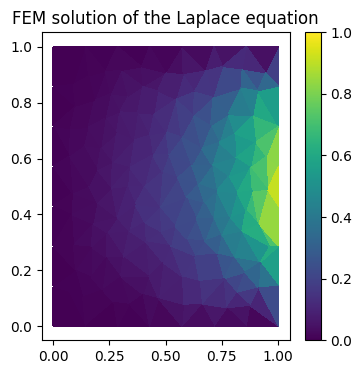

In [103]:
# Now we just have to solve the system of equations, to get the coefficients of the basis functions at the interior points
sol_interior = spsolve(global_stiffness_matrix_with_BC, rhs)

# We regroup the solution of the interior points with the boundary points
sol = np.zeros(n_vertices)

sol[interior_mask] = sol_interior
sol[~interior_mask] = mesh.boundary_values.flatten()

#Set the plot size 
plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, sol, shading='flat', vmin=0, vmax=1)
plt.colorbar()
plt.title('FEM solution of the Laplace equation')
plt.plot()



[]

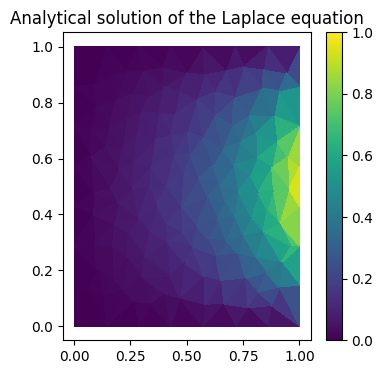

In [98]:
analytical_solution = np.sinh(mesh.vertices[:, 0] * np.pi)[:, np.newaxis] * np.sin(mesh.vertices[:, 1] * np.pi)[:, np.newaxis] / np.sinh(np.pi)

plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, analytical_solution.flatten(), shading='flat', vmin=0, vmax=1)
plt.colorbar()
plt.title('Analytical solution of the Laplace equation')
plt.plot()

[]

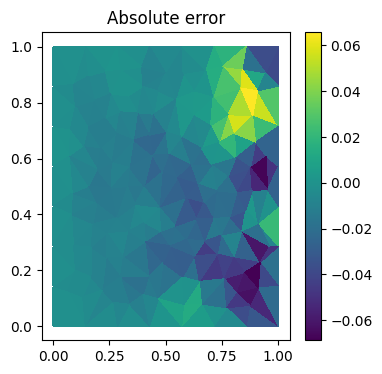

In [99]:
#Compute the relative error
absolute_error = (sol - analytical_solution.flatten()) 


plt.figure(figsize=(4, 4))
plt.tripcolor(mesh.vertices[:, 0], mesh.vertices[:, 1], mesh.faces, absolute_error, shading='flat')
plt.colorbar()
plt.title('Absolute error')
plt.plot()